# Setup

## Imports 
Just consolidating them here in this cell

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
from imageio import imread
import cv2
from os import listdir

import torch 
import albumentations as A
from PIL import Image 

## Paths 
Just for easy reference later

In [2]:
PATH_image_labels = '/kaggle/input/nfl-impact-detection/image_labels.csv'
PATH_image_folder = '/kaggle/input/nfl-impact-detection/images/'

## Dataframe for all helmets across all images
Contains all labeled data we'll need

In [3]:
dfHelmets = pd.read_csv(PATH_image_labels)
dfHelmets.head()

image   label  left  width  top  height
0  57503_000116_Endzone_frame443.jpg  Helmet  1099     16  456      15
1  57503_000116_Endzone_frame443.jpg  Helmet  1117     15  478      16
2  57503_000116_Endzone_frame443.jpg  Helmet   828     16  511      15
3  57503_000116_Endzone_frame443.jpg  Helmet   746     16  519      16
4  57503_000116_Endzone_frame443.jpg  Helmet   678     17  554      17

In [4]:
imgNames = listdir(PATH_image_folder)

In [5]:
print("There are a total of",len(dfHelmets),"helmets across",len(imgNames),"images.")

There are a total of 193736 helmets across 9947 images.


# Helper functions

In [6]:
#imgName = dfHelmets.values[0][0]

def getImgFromName(imgName):
    imgPath = PATH_image_folder+"/"+imgName
    print(imgPath)

    # TWO WAYS TO DISPLAY IMAGE 

    # Method 1: cv2 
    img = cv2.imread(imgPath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Method 2: imageio imread
    #img = imread(imgPath)
    
    return img

In [7]:
def getImageDF(imgName):
    dfImage = dfHelmets.loc[dfHelmets['image']==imgName]
    return dfImage

In [8]:
def getStartEndCoords(row): 
    label = row['label']
    left = row['left']
    width = row['width']
    top = row['top']
    height = row['height']
    
    # represents the top left corner of bounding box
    start_point = (left, top)

    # represents the bottom right corner of bounding box
    end_point = (left+width, top+height)
    
    return start_point, end_point

In [9]:
# set color and line thickness of bounding box
predColor = (0, 255, 255)
targetColor = (255, 0, 255)
thickness = 2

import copy

def addBoundingBoxes(img,dfImage):
    for index, row in dfImage.iterrows(): # for each bounding box in the img
        start_point, end_point = getStartEndCoords(row)

        # add bounding box of helmet to img
        cv2.rectangle(img, start_point, end_point, targetColor, thickness)
        
# img = addBoundingBoxes(img,dfImage)
# display the image 
# plt.imshow(img) 

In [10]:
def addTargetBoxes(img,targetBoxes): 
    for box in targetBoxes:
        cv2.rectangle(img,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  targetColor, 3)
    print("There are",len(targetBoxes),"helmets")

In [11]:
def addPredBoxes(img,outputBoxes,scores=None,threshold=0.5): 
    if scores is not None: # filter out predicted helmets which have a probablilty of <50% 
        indicesOfLikelyHelmets = [outputScores>threshold] 
        outputBoxes = outputBoxes[indicesOfLikelyHelmets]
    for box in outputBoxes:
        cv2.rectangle(img,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  predColor, 3)
    print("We detected",len(outputBoxes),"helmets")

## Albumentation 

In [ ]:
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

## Data Visualisation

/kaggle/input/nfl-impact-detection/images//57655_000176_Sideline_frame583.jpg
/kaggle/input/nfl-impact-detection/images//58088_002963_Sideline_frame135.jpg
/kaggle/input/nfl-impact-detection/images//58000_001306_Sideline_frame83.jpg


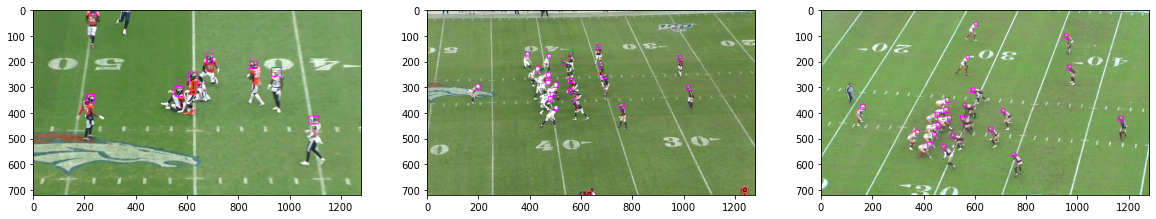

In [12]:
ind = 131
plt.figure(figsize=(20,10))

for imgName in imgNames[:3]: # just the first 3 images to test my loop
    
    # get image and corresponding dataframe containing bounding boxes
    img = getImgFromName(imgName)
    dfImage = getImageDF(imgName)
    
    imgWithbb = copy.deepcopy(img)
    
    # add bounding boxes of all helmets in the image
    addBoundingBoxes(imgWithbb,dfImage)
    
    # display the image 
    plt.subplot(ind),plt.imshow(imgWithbb) 
    ind += 1

# Faster R-CNN Model

## Dataset Class 

In [13]:
class NFLDataset(object):
    def __init__(self, df, image_dir):
    
        self.image_ids = df['image'].unique()
        self.df = df
        self.image_dir = image_dir
        self.labels_dict = {
            'Helmet':1, 
            'Helmet-Blurred':2, 
            'Helmet-Difficult':3, 
            'Helmet-Sideline':4,
            'Helmet-Partial':5
        }

    def __getitem__(self, idx:int):
        # load images ad masks
        image_id = self.image_ids[idx]
        image = np.array(Image.open(f'{self.image_dir}/{image_id}'))/225.0
        image = np.moveaxis(image, 2, 0)
        records = self.df[self.df["image"]==self.image_ids[idx]]
        boxes = []
        labels = []
        for i in range(records.shape[0]):
            img_data = records.iloc[i]
            x_min = img_data.left
            x_max = img_data.left + img_data.width
            y_min = img_data.top
            y_max = img_data.top + img_data.height
            boxes.append([x_min, y_min, x_max, y_max])
            label = self.labels_dict[img_data.label]
            labels.append(label)

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there are 5 classes 
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image  = torch.as_tensor(image , dtype = torch.float32)
        image_id = torch.tensor([idx])
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        
        return image, target, image_id

    def __len__(self):
        return self.image_ids.shape[0]

## Pretrained Model

In [15]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 6  
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [16]:
def collate_fn(batch):
    return tuple(zip(*batch))


train_dataset = NFLDataset(dfHelmets, PATH_image_folder)
valid_dataset = NFLDataset(dfHelmets, PATH_image_folder)
# split the dataset in train and test set
#indices = torch.randperm(len(dataset)).tolist()
indices = torch.randperm(len(train_dataset)).tolist()
train_cnt = int(0.9*len(indices))

train_dataset = torch.utils.data.Subset(train_dataset,indices[:train_cnt])
valid_dataset = torch.utils.data.Subset(valid_dataset,indices[train_cnt:])



train_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=collate_fn
)

valid_data_loader =  torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=collate_fn
)

In [17]:
if torch.cuda.is_available(): 
    device = torch.device('cuda')
else: 
    device = torch.device('cpu')
print(device)

cuda


In [18]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

There are 41 helmets


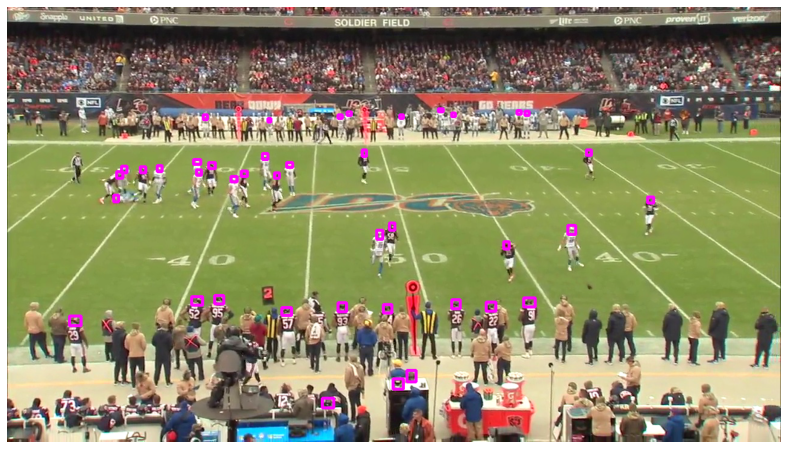

In [19]:
targetBoxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample = images[0].permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sampleTargetbb = copy.deepcopy(sample)
addTargetBoxes(sampleTargetbb,targetBoxes)
    
ax.set_axis_off()
ax.imshow(sampleTargetbb)

# Train 

In [20]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
#lr_scheduler = None

num_epochs = 1

In [21]:
loss = []
#iterations = []
for epoch in range(num_epochs):
    
    for i, batch in enumerate(train_data_loader):

        images, targets, image_ids = batch
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        model.train()
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"Iteration #{i} loss: {loss_value}")

        loss.append(loss_value)
        #iterations.append(i)

    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
        
    evaluate(model, valid_data_loader, device=device)

Iteration #0 loss: 3.148407459259033
Iteration #100 loss: 0.8556982278823853
Iteration #200 loss: 0.7785609364509583
Iteration #300 loss: 0.8064419627189636
Iteration #400 loss: 0.7117056250572205
Iteration #500 loss: 0.8452154397964478
Iteration #600 loss: 0.9035050868988037
Iteration #700 loss: 0.7887480854988098
Iteration #800 loss: 0.761042058467865
Iteration #900 loss: 0.7137446999549866
Iteration #1000 loss: 0.6768737435340881
Iteration #1100 loss: 0.5340161919593811


NameError: name 'evaluate' is not defined

## Visualise Loss

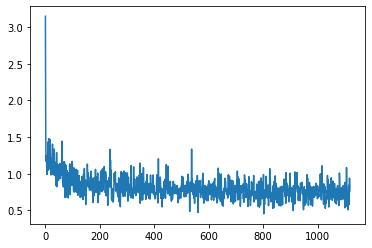

In [22]:
plt.plot(list(range(0,len(loss))), loss[0:])
plt.show()

In [23]:
torch.save(model.state_dict(), "frcnnresnet50.pth")

# Test

In [24]:
images, targets, image_ids = next(iter(valid_data_loader))
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

In [25]:
print(outputs[2])

{'boxes': tensor([[ 717.6052,  281.7924,  745.1395,  307.3079],
        [ 564.5978,  354.1519,  597.7770,  384.6369],
        [ 970.6386,  265.4959, 1000.1486,  292.9540],
        [ 798.8575,  375.5173,  830.0672,  406.3687],
        [ 624.6033,  192.1846,  652.3220,  225.7961],
        [ 163.5793,   60.8005,  191.9569,   91.6317],
        [  89.4786,  168.3759,  118.1976,  197.5421],
        [ 313.7518,  255.8469,  344.0200,  282.8839],
        [1152.2135,  168.6250, 1183.2465,  205.2140],
        [ 810.1042,  205.7144,  843.6080,  238.0219],
        [ 572.5818,   82.9713,  601.9240,  115.6546],
        [ 860.5854,  151.8935,  891.9808,  186.6676],
        [ 447.5588,  282.2768,  476.1811,  303.5606],
        [1157.7360,  236.4766, 1182.4634,  261.1328],
        [ 574.3582,  272.8956,  601.5555,  295.9900],
        [1031.3319,  480.9677, 1041.5847,  493.7539],
        [1039.6754,  467.9443, 1051.2377,  480.2117],
        [ 466.7989,   86.8128,  477.6117,   99.3115],
        [ 458.7252

## Visualise target vs predicted bounding boxes

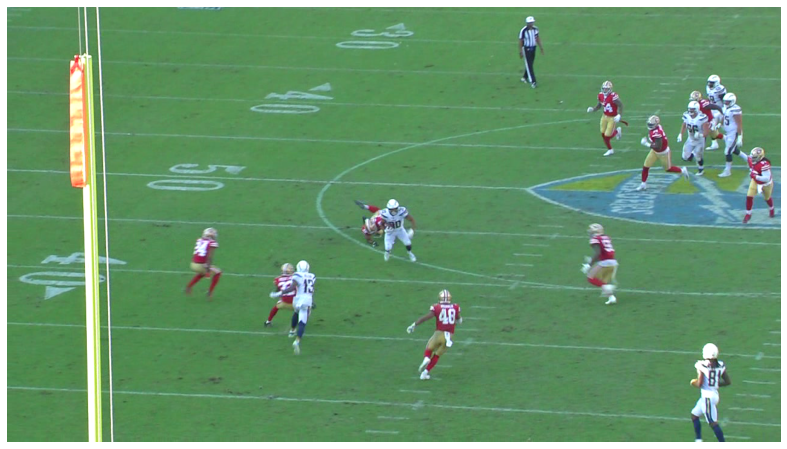

In [31]:
sample = images[6].permute(1,2,0).cpu().numpy()
targetBoxes = targets[6]['boxes'].cpu().numpy().astype(np.int32)
outputBoxes = outputs[6]['boxes'].detach().numpy().astype(np.int32)
outputScores = outputs[6]["scores"].detach().numpy()
outputLabels = outputs[6]["labels"].detach().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.set_axis_off()
ax.imshow(sample)

There are 15 helmets


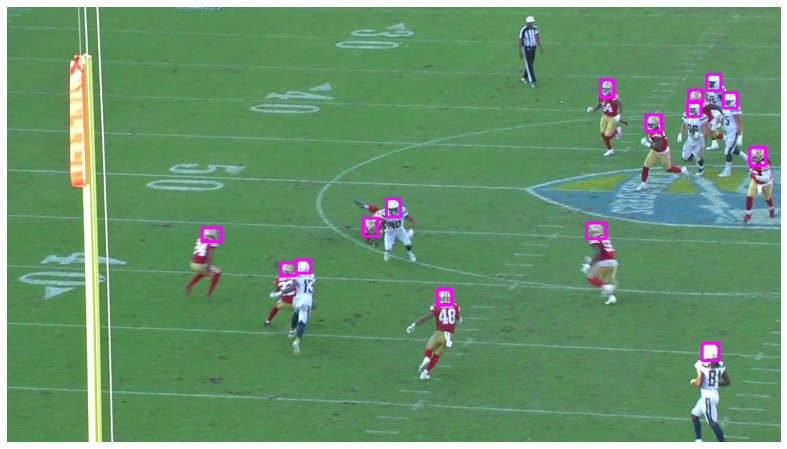

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sampleTargetbb = copy.deepcopy(sample)
addTargetBoxes(sampleTargetbb,targetBoxes)
    
ax.set_axis_off()
ax.imshow(sampleTargetbb)

We detected 32 helmets


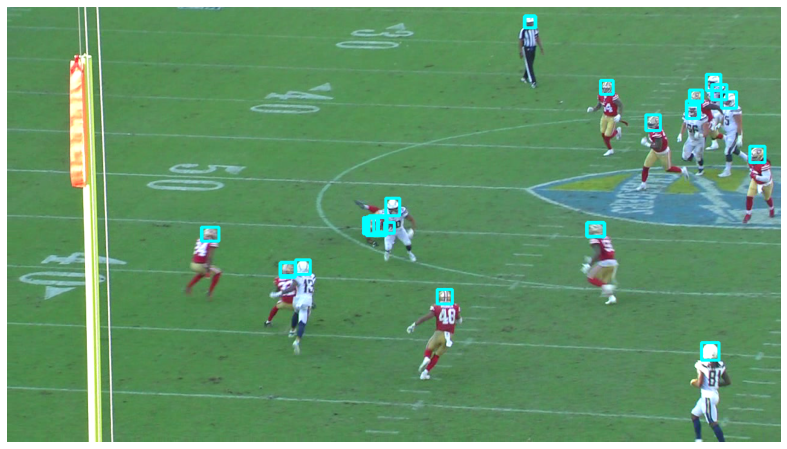

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

samplePredbb = copy.deepcopy(sample)
addPredBoxes(samplePredbb,outputBoxes)
    
ax.set_axis_off()
ax.imshow(samplePredbb)

In [32]:
print(outputScores)
print(outputBoxes)
print(outputLabels)

[0.9909196  0.978111   0.9770313  0.97296166 0.9675655  0.9616291
 0.9573203  0.9562201  0.95598394 0.95385283 0.8961104  0.8683111
 0.7752848  0.7495302  0.71087354 0.64152145 0.30816138 0.22736618
 0.21493115 0.16616334 0.13228434 0.12242494 0.10373954 0.09875251
 0.09338237 0.08829653 0.0679599  0.06659734 0.06265356 0.06049376
 0.05844438 0.05554429]
[[ 711  467  736  491]
 [ 626  316  649  345]
 [1181  140 1206  167]
 [ 981  121 1002  144]
 [ 477  418  501  442]
 [1123  155 1145  184]
 [1156  111 1180  138]
 [1148  555 1177  584]
 [1056  178 1080  204]
 [1228  230 1253  257]
 [1128  137 1150  156]
 [ 452  422  477  445]
 [ 321  364  350  387]
 [ 598  345  628  376]
 [ 958  357  988  379]
 [ 589  348  614  375]
 [ 959  356  987  380]
 [ 322  364  350  387]
 [ 591  349  612  375]
 [ 855   15  874   34]
 [1128  137 1150  157]
 [ 452  422  476  447]
 [ 594  347  626  378]
 [1165  128 1190  153]
 [1166  128 1190  153]
 [ 606  348  627  372]
 [ 624  356  640  374]
 [1129  137 1149  156]

In [45]:
labelsList = [None, 
              'Helmet',
              'Helmet-Blurred', 
              'Helmet-Difficult', 
              'Helmet-Sideline',
              'Helmet-Partial']

## Analyse scores of different helmet labels

In [63]:
allOutputLabels = []
allOutputLabelNames = []
allOutputScores = []

for i in range(len(images)): 
    sample = images[i].permute(1,2,0).cpu().numpy()
    targetBoxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    outputBoxes = outputs[i]['boxes'].detach().numpy().astype(np.int32)
    outputScores = outputs[i]["scores"].detach().numpy()
    outputLabels = outputs[i]["labels"].detach().numpy()
    
    outputLabelNames = []
    for l in outputLabels: 
        outputLabelNames.append(labelsList[l])
        
    allOutputLabels.extend(outputLabels)
    allOutputLabelNames.extend(outputLabelNames)
    allOutputScores.extend(outputScores)

dfHelmetOutputs = pd.DataFrame(
    {'labels': allOutputLabels,
     'label name': allOutputLabelNames,
     'scores': allOutputScores
    })
dfHelmetOutputs

labels        label name    scores
0         1            Helmet  0.830751
1         2    Helmet-Blurred  0.672053
2         1            Helmet  0.623904
3         2    Helmet-Blurred  0.618222
4         1            Helmet  0.608658
..      ...               ...       ...
446       3  Helmet-Difficult  0.080280
447       1            Helmet  0.069669
448       1            Helmet  0.062624
449       2    Helmet-Blurred  0.058124
450       2    Helmet-Blurred  0.055140

[451 rows x 3 columns]

array([[<AxesSubplot:title={'center':'Helmet'}>,
        <AxesSubplot:title={'center':'Helmet-Blurred'}>],
       [<AxesSubplot:title={'center':'Helmet-Difficult'}>,
        <AxesSubplot:title={'center':'Helmet-Partial'}>],
       [<AxesSubplot:title={'center':'Helmet-Sideline'}>, <AxesSubplot:>]],
      dtype=object)

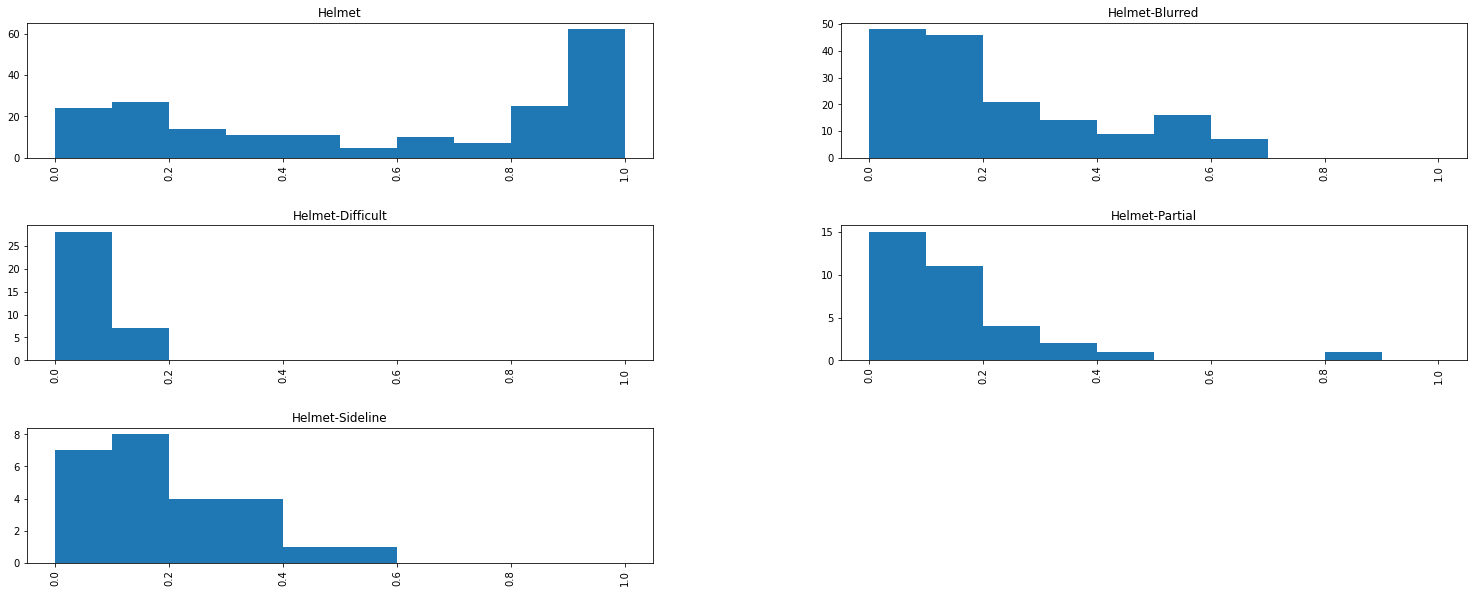

In [83]:
dfHelmetOutputs.hist(column="scores", by="label name", bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], figsize=(25, 10))

## Adding thresholds to filter helmets

We detected 27 helmets


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  after removing the cwd from sys.path.


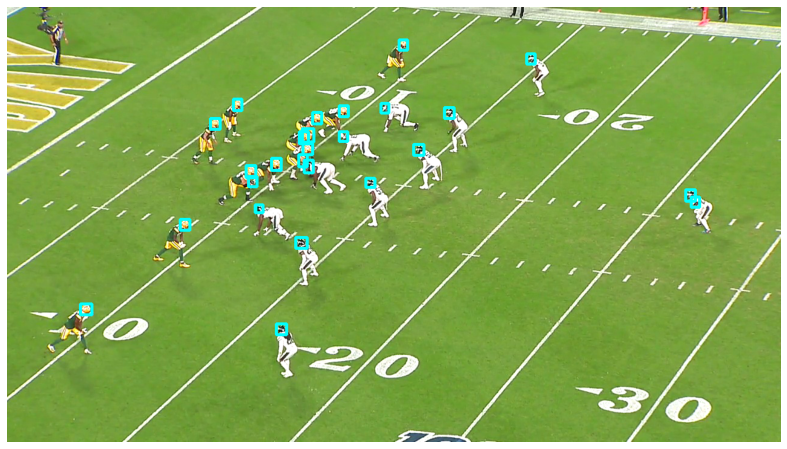

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

samplePredbb = copy.deepcopy(sample)
addPredBoxes(samplePredbb,outputBoxes,scores=outputScores, threshold=0.3)
    
ax.set_axis_off()
ax.imshow(samplePredbb)

We detected 23 helmets


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  after removing the cwd from sys.path.


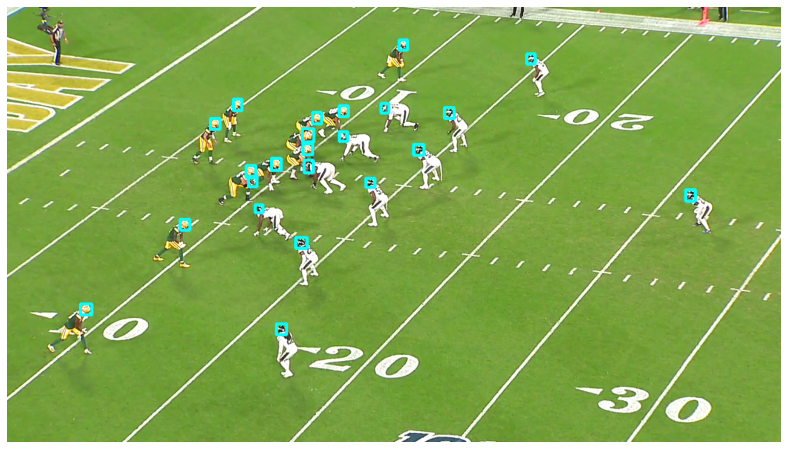

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

samplePredbb = copy.deepcopy(sample)
addPredBoxes(samplePredbb,outputBoxes,scores=outputScores)
    
ax.set_axis_off()
ax.imshow(samplePredbb)

We detected 17 helmets


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  after removing the cwd from sys.path.


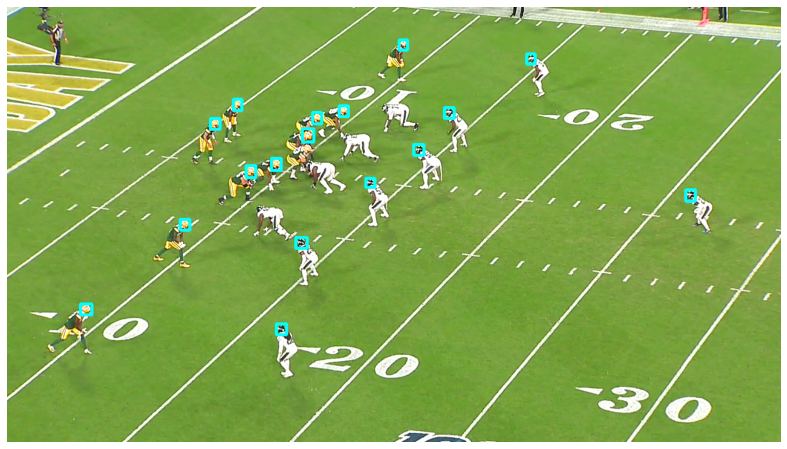

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

samplePredbb = copy.deepcopy(sample)
addPredBoxes(samplePredbb,outputBoxes,scores=outputScores, threshold=0.8)
    
ax.set_axis_off()
ax.imshow(samplePredbb)